In [1]:
import pickle

import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata, kendalltau, spearmanr

import plotly.graph_objects as go
from tqdm.notebook import tqdm
from pathlib import Path

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
display(df_users.head())

timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [3]:
topics = list("abcdefgh")
nums = list(range(9))
num2topic = dict(zip(nums, topics))
topic2num = dict(zip(topics, nums))
print(f"{topic2num} {num2topic}")
deltas = ["10", "21", "32", "43", "54"]

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7} {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}


In [4]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")
df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)
df_evals.index = [f"u{u}" for u in df_evals["id"]]

display(df_evals.head())

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()
print(get_change("u2337", num2topic[0]))

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,g_delta_10,g_delta_21,g_delta_32,g_delta_43,g_delta_54,h_delta_10,h_delta_21,h_delta_32,h_delta_43,h_delta_54
u2658,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
u2297,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2601,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2338,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u2638,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[3.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

df_annot_posts = pd.read_csv("./DSock/posts_anno_labels.csv")
df_posts = df_posts.merge(df_annot_posts[["post_id", "majority_topic_label", "majority_sent_label"]], left_on="PostID", right_on="post_id")

df_annot_comts = pd.read_csv("./DSock/comments_anno_labels.csv")
df_comts = df_comts.merge(df_annot_comts[["comment_id", "majority_topic_label", "majority_sent_label"]], left_on="id", right_on="comment_id")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [6]:
post_comments = {f"p{p}": [] for p in df_posts["PostID"].values}
for c, p in df_comts[["id", "PostId"]].values:
    if f"p{p}" in post_comments:
        post_comments[f"p{p}"].append(f"c{c}")
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, u, t, polar, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{p}", id=p, kind="post", time=t, user=u, polar=polar, score=score, topic=topic)

for c, u, p, t, polar, score, topic in df_comts[["id", "CommenterId", "PostId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"c{c}", id=c, kind="comt", time=t, user=u, polar=polar, score=score, topic=topic)
        G.add_edge(f"c{c}", f"p{p}", kind="known", time=t, weight=1)
        # G.add_edge(f"p{p}", f"c{c}", kind="known", time=t, weight=1)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"l{l}", user=f"u{u}", post=f"p{p}", time=t, id=l, kind="like",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"l{l}", time=t, weight=1, kind="infer")
        G.add_edge(f"l{l}", f"p{p}", time=t, weight=1, kind="known")

for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"v{v}", user=f"u{u}", post=f"p{p}", time=t, id=v, kind="view",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"v{v}", time=t, weight=1, kind="infer")
        G.add_edge(f"v{v}", f"p{p}", time=t, weight=1, kind="infer")
        if s == "t":
            for c in post_comments[f"p{p}"]:
                if c in G.nodes:
                    G.add_edge(f"v{v}", c, time=t, weight=1, kind="infer")
user_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes and s != "t":
        user_view[f"u{u}"].add(f"v{v}")

single_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v, s in df_views[["UserId", "PostId", "createdAt", "id", "singleView"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes and s == "t":
        single_view[f"u{u}"].add(f"v{v}")

print(f"user view: {sum([len(user_view[u]) for u in user_view])}")
print(f"single view: {sum([len(single_view[u]) for u in single_view])}")

for p in tqdm(G):
    if p[0] in ["p", "c"]:
        u = f"u{G.nodes[p]['user']}"
        for v in user_view[u] | single_view[u]:
            if G.nodes[v]["time"] <= G.nodes[p]["time"]:
                G.add_edge(p, v, time=G.nodes[v]["time"], weight=1, kind="infer")

user view: 210543
single view: 3808


In [7]:
with open("res/pagerank/0.85-0.5-0.5.pkl", "rb") as fp:
    d = pickle.load(fp)

In [8]:
df_users[df_users["id"] == 2340]

,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
7,A1CGW3DQ5JRSJH,Asia_3576,2340,f,t,f,0,0,0,0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN


In [9]:
user_list = df_users["id"].tolist()
# user_list = df_users[df_users["isObserver"] == "f"]["id"].tolist()

In [10]:
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]
pr_alpha = 0.85
beta_a = 0.5
beta_b = 0.5
keyq = [(node_name, t, topic, polar, pr_alpha, beta_a, beta_b)
        for node_name in obsr_list for t in range(1,6) for topic in range(8) for polar in [0, 2]
       ]

keyq = list(filter(lambda x: get_change(x[0], num2topic[x[2]])[x[1]-1]*(1-x[3]) > 0, tqdm(keyq)))

In [11]:
property_full = {k: d[k]["full_graph"] for k in tqdm(keyq)}
property_exps = {k: d[k]["exps_graph"] for k in tqdm(keyq)}

df_full = pd.DataFrame.from_dict(property_full, orient="index")
df_exps = pd.DataFrame.from_dict(property_exps, orient="index")

In [12]:
use_color = sns.color_palette("Set1")
use_color

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [13]:
pd.DataFrame.from_dict({
    ("Full Influence Graph", "mean"): df_full.mean(axis=0),
    ("Full Influence Graph", "std"): df_full.std(axis=0),
    ("Expression only Influence Graph", "mean"): df_exps.mean(axis=0),
    ("Expression only Influence Graph", "std"): df_exps.std(axis=0),
}).T

nodes        edges  components  \
Full Influence Graph            mean   462.183099  1476.161972    1.000000   
                                std   1225.934304  4455.952356    0.000000   
Expression only Influence Graph mean    14.711268     5.619718    9.091549   
                                std     26.742158    12.095209   15.051168   

                                       density  diameter    degree  
Full Influence Graph            mean  0.023673  3.021127  1.305359  
                                std   0.059780  2.980952  1.273526  
Expression only Influence Graph mean  0.008994  0.000000  0.149261  
                                std   0.018341  0.000000  0.208950

In [14]:
pab = [(p, a, b)
    for p in [0.85, 0.9, 0.7, 0.5, 0.3, 0.1]
    for a in [0.5, 0.9, 0.7, 0.3, 0.1]
    for b in [0.5, 0.9, 0.7, 0.3, 0.1]
]
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]

In [15]:
def pr2rank(pr_value):
    ret = {u: 0 for u in user_list}
    for n in pr_value:
        if n[0] in ["p", "c"]:
            ret[G.nodes[n]["user"]] += pr_value[n]
    rank_value = [-ret[u] for u in user_list]
    rank = rankdata(rank_value, "max")
    # print(rankdata(rank, "min"))
    return dict(zip(user_list, rank))

def get_params(p, a, b):
    fpath = Path(f"res/pagerank/{p}-{a}-{b}.pkl")
    if not fpath.exists():
        return None
    with open(fpath, "rb") as fp:
        d = pickle.load(fp)
    keyq = [(node_name, t, topic, polar, p, a, b)
            for node_name in obsr_list for t in range(1, 6) for topic in range(8) for polar in [0, 2]
            ]
    # keyq = list(filter(lambda x: get_change(x[0], num2topic[x[2]])[x[1]-1]*(1-x[3]) > 0, keyq))
    ranks = [(k, pr2rank(d[k]["pr"])) for k in keyq]
    return ranks

ret = [get_params(*tup) for tup in tqdm(pab)]

In [16]:
keys = [x[0] for r in ret if r is not None for x in r]
values = [x[1] for r in ret if r is not None for x in r]
rank_dict = dict(zip(keys, values))

df_inf = pd.DataFrame.from_dict(rank_dict, orient="index")
display(df_inf.head())

2658  2297  2601  2338  2638  2701  2340  2719  \
u2297 1 0 0 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
          2 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
        1 0 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
          2 0.85 0.5 0.5   116   116   116   116   116   116   116   116   
        2 0 0.85 0.5 0.5   116   116   116   116   116   116   116   116   

                          2667  2342  ...  2636  2734  2657  2441  2714  2313  \
u2297 1 0 0 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
          2 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
        1 0 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
          2 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   
        2 0 0.85 0.5 0.5   116   116  ...   116   116   116   116   116   116   

                          2337  2350  2703  2749  
u2297 1 0 0 0.85 0.5 0.5   116   116   116   116  
          2 0.85 0.5 0.5   116   116   116   116  
        1 0 0.85 0.5 0.5   116   116   116   116  
          2 0.85 0.5 0.5   116   116   116   116  
        2 0 0.85 0.5 0.5   116   116   116   116  

[5 rows x 116 columns]

In [17]:
avg_inf = df_inf.mean(axis=0, level=[1, 4, 5, 6])
display(avg_inf.head(10))

,,,,2658,2297,2601,2338,2638,2701,2340,2719,2667,2342,...,2636,2734,2657,2441,2714,2313,2337,2350,2703,2749
1,0.85,0.5,0.5,115.582721,116.0,115.797794,116.0,110.200368,112.474265,116.0,106.113971,110.806985,116.0,...,114.979779,114.180147,105.430147,116.000000,116.000000,116.0,116.0,116.0,115.404412,116.0
2,0.85,0.5,0.5,103.750000,116.0,109.814338,116.0,112.913603,102.693015,116.0,104.783088,101.387868,116.0,...,112.533088,111.498162,105.011029,110.860294,110.479779,116.0,116.0,116.0,112.704044,116.0
3,0.85,0.5,0.5,103.593750,116.0,105.077206,116.0,112.347426,102.626838,116.0,106.123162,98.810662,116.0,...,114.389706,109.123162,107.123162,110.647059,111.125000,116.0,116.0,116.0,107.378676,116.0
4,0.85,0.5,0.5,106.795956,116.0,99.784926,116.0,109.172794,96.941176,116.0,102.505515,94.645221,116.0,...,114.202206,105.514706,106.698529,110.235294,110.568015,116.0,116.0,116.0,106.272059,116.0
5,0.85,0.5,0.5,103.779412,116.0,98.584559,116.0,105.556985,96.950368,116.0,102.676471,93.711397,116.0,...,114.797794,105.250000,106.702206,112.088235,110.597426,116.0,116.0,116.0,100.487132,116.0
1,0.85,0.5,0.9,115.582721,116.0,115.797794,116.0,110.200368,112.501838,116.0,106.097426,110.806985,116.0,...,114.979779,114.180147,105.430147,116.000000,116.000000,116.0,116.0,116.0,115.419118,116.0
2,0.85,0.5,0.9,103.748162,116.0,109.825368,116.0,112.913603,102.775735,116.0,104.724265,101.424632,116.0,...,112.533088,111.540441,105.011029,110.854779,110.431985,116.0,116.0,116.0,112.784926,116.0
3,0.85,0.5,0.9,103.604779,116.0,105.009191,116.0,112.347426,102.691176,116.0,106.101103,99.069853,116.0,...,114.384191,109.281250,107.123162,110.647059,111.125000,116.0,116.0,116.0,107.558824,116.0
4,0.85,0.5,0.9,106.799632,116.0,99.825368,116.0,109.172794,97.036765,116.0,102.477941,94.865809,116.0,...,114.191176,105.700368,106.698529,110.235294,110.568015,116.0,116.0,116.0,106.597426,116.0
5,0.85,0.5,0.9,103.762868,116.0,98.584559,116.0,105.556985,96.987132,116.0,102.659926,93.847426,116.0,...,114.794118,105.560662,106.702206,112.088235,110.606618,116.0,116.0,116.0,100.683824,116.0


In [18]:
pab_done = set([k[4:] for k in keys])
pab_done = [tup for tup in pab if tup in pab_done]

In [19]:
df_user_express = pd.read_csv("./DSock/User_Expressed_Influence_Rank.csv")
display(df_user_express.head())

df_active_user_express = pd.read_csv("./DSock/Active_User_Expressed_Influence_Rank.csv")
display(df_active_user_express.head())

,MTurk_ID,username,id,Role,survey,mentions,per_rank
0,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,1,0,0.0
1,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,2,0,0.0
2,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,3,0,0.0
3,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,4,0,0.0
4,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,5,0,0.0


,MTurk_ID,username,id,Role,survey,mentions
0,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,1,0
1,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,2,0
2,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,3,0
3,APRZ7BR8C0ZMQ,Allison_2018,2389,sockpuppet,4,0
4,AKK6H2YXK4RF6,Allison_2019,2627,participant,1,5


In [20]:
def jaccard(col1, col2, num=10):
    r1 = set(col1.nlargest(num).index)
    r2 = set(col2.nlargest(num).index)
    ret = len(r1&r2)/len(r1|r2) if len(r1|r2) > 0 else np.nan
    return ret

def rank_metrics(col1, col2):
    ret1 = {
        "spearman": dict(zip(["correlation", "pvalue"], spearmanr(col1, col2))),
        "kendaltau": dict(zip(["correlation", "pvalue"], kendalltau(col1, col2))),
    }
    
    ret2 = {
        f"jaccard-{j}": {"correlation": jaccard(col1, col2, j), "pvalue": None}
        for j in [10, 20, 30, 40, 50, 100]
    }
    
    return {**ret1, **ret2}

# print(jaccard(df_user_express["per_rank"], df_cor[(0.85, 0.5,0.5)].rank(ascending=False, pct=True, method="max")))
# print(rank_metrics(-df_user_express["per_rank"], df_cor[(0.85, 0.5, 0.5)]))

In [21]:
# pd.set_option('precision', 3)

In [22]:
df_cor = {tup: [avg_inf.loc[(t, *tup), n] if (t, *tup) in avg_inf.index else None for n, t in df_user_express[["id", "survey"]].values] for tup in tqdm(pab_done)}
df_cor = pd.DataFrame.from_dict(df_cor)
df_cor = pd.concat([df_cor, df_user_express], axis=1).dropna(axis=0)

res_all = {tup: rank_metrics(
    df_cor["mentions"].rank(ascending=False, pct=True, method="dense"),
    df_cor[tup].rank(ascending=True, pct=True, method="dense"))
           for tup in tqdm(pab_done)}
df_res = pd.concat([pd.DataFrame(res_all[tup]) for tup in tqdm(pab_done)], keys=pab_done)

print(df_res.loc[(slice(None), slice(None), slice(None), "correlation")].max())
display(df_res)

idxmax = df_res.loc[(slice(None), slice(None), slice(None), "correlation")].idxmax()
print(idxmax)

display(pd.concat([df_res.loc[(*ind, slice(None)), :] for ind in set(idxmax)], axis=0))


spearman       0.458108
kendaltau      0.386114
jaccard-10     0.052632
jaccard-20     0.111111
jaccard-30     0.132075
jaccard-40     0.142857
jaccard-50     0.219512
jaccard-100    0.351351
dtype: float64


spearman     kendaltau  jaccard-10  jaccard-20  \
0.85 0.5 0.5 correlation  4.576154e-01  3.855895e-01    0.052632    0.111111   
             pvalue       4.189101e-31  1.429167e-28         NaN         NaN   
         0.9 correlation  4.574313e-01  3.854058e-01    0.052632    0.111111   
             pvalue       4.454657e-31  1.513329e-28         NaN         NaN   
         0.7 correlation  4.576086e-01  3.855852e-01    0.052632    0.111111   
...                                ...           ...         ...         ...   
0.10 0.1 0.7 pvalue       3.641948e-31  1.212885e-28         NaN         NaN   
         0.3 correlation  4.580120e-01  3.859431e-01    0.052632    0.111111   
             pvalue       3.669426e-31  1.269754e-28         NaN         NaN   
         0.1 correlation  4.577103e-01  3.857025e-01    0.052632    0.111111   
             pvalue       4.058450e-31  1.375694e-28         NaN         NaN   

                          jaccard-30  jaccard-40  jaccard-50  jaccard-100  
0.85 0.5 0.5 correlation    0.132075    0.142857    0.219512     0.351351  
             pvalue              NaN         NaN         NaN          NaN  
         0.9 correlation    0.132075    0.142857    0.219512     0.351351  
             pvalue              NaN         NaN         NaN          NaN  
         0.7 correlation    0.132075    0.142857    0.219512     0.351351  
...                              ...         ...         ...          ...  
0.10 0.1 0.7 pvalue              NaN         NaN         NaN          NaN  
         0.3 correlation    0.111111    0.142857    0.219512     0.351351  
             pvalue              NaN         NaN         NaN          NaN  
         0.1 correlation    0.132075    0.142857    0.219512     0.351351  
             pvalue              NaN         NaN         NaN          NaN  

[300 rows x 8 columns]

spearman        (0.1, 0.1, 0.5)
kendaltau       (0.1, 0.1, 0.5)
jaccard-10     (0.85, 0.5, 0.5)
jaccard-20     (0.85, 0.5, 0.5)
jaccard-30     (0.85, 0.5, 0.5)
jaccard-40     (0.85, 0.5, 0.5)
jaccard-50     (0.85, 0.5, 0.5)
jaccard-100    (0.85, 0.5, 0.5)
dtype: object


spearman     kendaltau  jaccard-10  jaccard-20  \
0.10 0.1 0.5 correlation  4.581080e-01  3.861135e-01    0.052632    0.111111   
             pvalue       3.553506e-31  1.203645e-28         NaN         NaN   
0.85 0.5 0.5 correlation  4.576154e-01  3.855895e-01    0.052632    0.111111   
             pvalue       4.189101e-31  1.429167e-28         NaN         NaN   

                          jaccard-30  jaccard-40  jaccard-50  jaccard-100  
0.10 0.1 0.5 correlation    0.111111    0.142857    0.219512     0.351351  
             pvalue              NaN         NaN         NaN          NaN  
0.85 0.5 0.5 correlation    0.132075    0.142857    0.219512     0.351351  
             pvalue              NaN         NaN         NaN          NaN

In [23]:
df_cor = {tup: [avg_inf.loc[(t, *tup), n] if (t, *tup) in avg_inf.index else None for n, t in df_active_user_express[["id", "survey"]].values] for tup in tqdm(pab_done)}

df_cor = pd.DataFrame.from_dict(df_cor)
df_cor = pd.concat([df_cor, df_active_user_express], axis=1).dropna(axis=0)

res_all = {tup: rank_metrics(
    df_cor["mentions"].rank(ascending=False, pct=True, method="dense"),
    df_cor[tup].rank(ascending=True, pct=True, method="dense"))
           for tup in tqdm(pab_done)}
df_res = pd.concat([pd.DataFrame(res_all[tup]) for tup in tqdm(pab_done)], keys=pab_done)
print(df_res.loc[(slice(None), slice(None), slice(None), "correlation")].max())
display(df_res)

idxmax = df_res.loc[(slice(None), slice(None), slice(None), "correlation")].idxmax()
print(idxmax)

display(pd.concat([df_res.loc[(*ind, slice(None)), :] for ind in set(idxmax)], axis=0))


spearman       0.488073
kendaltau      0.414159
jaccard-10     0.000000
jaccard-20     0.025641
jaccard-30     0.200000
jaccard-40     0.194030
jaccard-50     0.204819
jaccard-100    0.298701
dtype: float64


spearman     kendaltau  jaccard-10  jaccard-20  \
0.85 0.5 0.5 correlation  4.877905e-01  4.137128e-01         0.0    0.025641   
             pvalue       2.027170e-25  2.704443e-23         NaN         NaN   
         0.9 correlation  4.876202e-01  4.135852e-01         0.0    0.025641   
             pvalue       2.118207e-25  2.793197e-23         NaN         NaN   
         0.7 correlation  4.878014e-01  4.137320e-01         0.0    0.025641   
...                                ...           ...         ...         ...   
0.10 0.1 0.7 pvalue       1.992425e-25  2.508012e-23         NaN         NaN   
         0.3 correlation  4.878018e-01  4.137959e-01         0.0    0.025641   
             pvalue       2.021280e-25  2.646839e-23         NaN         NaN   
         0.1 correlation  4.873828e-01  4.134290e-01         0.0    0.025641   
             pvalue       2.251942e-25  2.900432e-23         NaN         NaN   

                          jaccard-30  jaccard-40  jaccard-50  jaccard-100  
0.85 0.5 0.5 correlation         0.2     0.19403    0.204819     0.298701  
             pvalue              NaN         NaN         NaN          NaN  
         0.9 correlation         0.2     0.19403    0.204819     0.298701  
             pvalue              NaN         NaN         NaN          NaN  
         0.7 correlation         0.2     0.19403    0.204819     0.298701  
...                              ...         ...         ...          ...  
0.10 0.1 0.7 pvalue              NaN         NaN         NaN          NaN  
         0.3 correlation         0.2     0.19403    0.204819     0.298701  
             pvalue              NaN         NaN         NaN          NaN  
         0.1 correlation         0.2     0.19403    0.204819     0.298701  
             pvalue              NaN         NaN         NaN          NaN  

[300 rows x 8 columns]

spearman        (0.1, 0.1, 0.5)
kendaltau       (0.1, 0.1, 0.5)
jaccard-10     (0.85, 0.5, 0.5)
jaccard-20     (0.85, 0.5, 0.5)
jaccard-30     (0.85, 0.5, 0.5)
jaccard-40     (0.85, 0.5, 0.5)
jaccard-50     (0.85, 0.5, 0.5)
jaccard-100    (0.85, 0.5, 0.5)
dtype: object


spearman     kendaltau  jaccard-10  jaccard-20  \
0.10 0.1 0.5 correlation  4.880726e-01  4.141590e-01         0.0    0.025641   
             pvalue       1.884808e-25  2.428197e-23         NaN         NaN   
0.85 0.5 0.5 correlation  4.877905e-01  4.137128e-01         0.0    0.025641   
             pvalue       2.027170e-25  2.704443e-23         NaN         NaN   

                          jaccard-30  jaccard-40  jaccard-50  jaccard-100  
0.10 0.1 0.5 correlation         0.2     0.19403    0.204819     0.298701  
             pvalue              NaN         NaN         NaN          NaN  
0.85 0.5 0.5 correlation         0.2     0.19403    0.204819     0.298701  
             pvalue              NaN         NaN         NaN          NaN

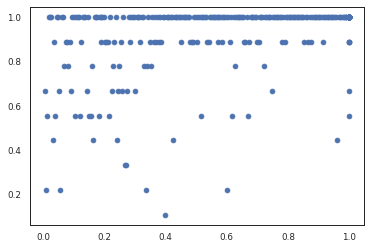

In [24]:
x = df_cor[(0.1, 0.1, 0.5)].rank(ascending=True, pct=True, method="dense")
y = df_cor["mentions"].rank(ascending=False, pct=True, method="dense")

plt.scatter(x, y)